In [44]:
import pandas as pd
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
import matplotlib.pyplot as plt
import seaborn as sns


In [131]:
res_dir = 'res'
experiments = ['mrcv_mites','mrcv_all','sun_all','sun_mites']
#experiments = ['sun_all','sun_mites']
#res_dir = 'all_res'
path = '../data/shortstack/%s/Results.txt'
path_annotation = '../data/introns.gff3'
path_annotation_promoters = '../data/promoters.gff3'
path_mites = "../data/mites_consensus.fasta"
path_mites_res = '../data/res/mites_prod.fasta'
path_res = '../data/res/all_results.csv'
path_mirna_seq = '../data/res/mirna.y.fasta'
path_mirna_seq_trep = '../data/res/mirna.y.trep.fasta'
path_mirna_mites_seq = '../data/res/mirna.mites.y.fasta'
path_mirna_mature = '../data/res/mirna.y.mature.csv'
path_res_seq = '../data/res/all_results.fasta'

path_genome = '../data/Triticum_aestivum.IWGSC.dna.toplevel.fa'
path_blast_res_mirna_mites = '../data/res/blast_mirna_mites.csv'
path_blast_res_mites_mirna = '../data/res/blast_mites_mirna.csv'



path_mirbase = '../data/mature.fa'

In [46]:
### Load shortstack results
dfs = {}
for experiment in experiments:
    experiment_path = path % (experiment,)
    df = pd.read_csv(experiment_path, sep='\t')
    df['Name'] = experiment + '_' + df['Name']
    print('Experiment:', experiment)
    print('All results:',len(df.index))
    #df = df[df.MIRNA == 'Y']
    #print('Only miRNAs:',len(df.index))
    df = df[df.Reads > 10]
    print('Only hotspots with +10 reads:',len(df.index))
    #df = df[df['21'] > 5]
    #print('Only miRNAs 21nt +5 reads:',len(df.index))
    print('*' * 10)
    dfs[experiment] = df

Experiment: mrcv_mites
All results: 1211339
Only hotspots with +10 reads: 37695
**********
Experiment: mrcv_all
All results: 38532
Only hotspots with +10 reads: 38532
**********
Experiment: sun_all
All results: 157492
Only hotspots with +10 reads: 157492
**********


KeyboardInterrupt: 

In [ ]:
dfs = [ v for v in dfs.values() ]

In [ ]:
df = pd.concat(dfs)

In [ ]:
len(df.index)

In [ ]:
df.head(2)

In [ ]:
#rename correctly all loci

In [ ]:
df['Name'] = df['Name'].str.split('|').str[0]

In [ ]:
df.head(2)

In [ ]:
df['seqname'] = df['#Locus'].str.split(':').str[0]
df['position'] = df['#Locus'].str.split(':').str[1]
df['start'] = df.position.str.split('-').str[0].astype(int)
df['end'] = df.position.str.split('-').str[1].astype(int)

In [ ]:
df['Name'] = df['Name'] + '_' + df['seqname'] + '_' + df['start'].astype(str) + '_' + df['end'].astype(str)

In [ ]:
df.head(2)

In [ ]:
df[df.duplicated(['Name'],keep=False)]

In [ ]:
df = df.reset_index(drop=True)


In [ ]:
print(len(df.index))

In [ ]:
df[df.index.isin(['876749','876750','876751','27433'])]

In [ ]:
df_sep = {}
for seqname in df.seqname.unique():
    df_sep[seqname] = df[df.seqname == seqname]


In [ ]:
min_distance = 150
duplicated = []
for k,v in df.iterrows():
    if k in duplicated:
        continue
    other = df_sep[v.seqname]
    other = other[(other.index != k) & 
                (other.MajorRNA == v.MajorRNA) &
                (abs(other.start - v.start) <= min_distance) & 
                (abs(other.end - v.end) <= min_distance)]
    if len(other.index) > 0:
        duplicated += other.index.tolist()

In [ ]:
duplicated = set(duplicated)
print(len(duplicated))

In [ ]:
print(len(df.index))

In [ ]:
df = df[~df.index.isin(duplicated)]
count_total = len(df.index)
count_total

In [ ]:
df.MIRNA.value_counts()

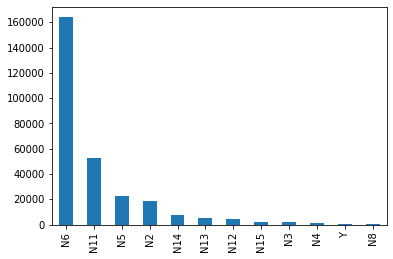

In [24]:
df.MIRNA.value_counts().plot(kind='bar')

In [25]:
df = df[df.MIRNA == 'Y']
print('Only miRNAs:',len(df.index))

Only miRNAs: 270


In [26]:
 df.groupby('DicerCall').count()['Name']

DicerCall
20     18
21    175
22     35
23      7
24     35
Name: Name, dtype: int64

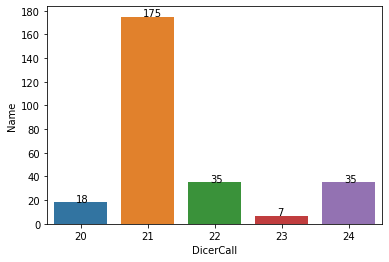

In [27]:
df_plot = df.groupby('DicerCall').count()
from matplotlib.ticker import MaxNLocator
from matplotlib import pyplot
ax = sns.barplot(x = df_plot.index, y = df_plot.Name)
x_offset = -0.07
y_offset = 0.15
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

for p in ax.patches:
    b = p.get_bbox()
    val = int(b.y1)
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))
ax
pyplot.savefig('../data/res/mirna_sizes.png',transparent=True, bbox_inches='tight', pad_inches=0)

In [28]:
df.head(3)

,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,Long,20,21,22,23,24,seqname,position,start,end
519,1A:169645857-169646029,mrcv_mites_MITE_T_62663_1A_169645857_169646029,173,16,0.126,3,1.000,+,UAGAGAUUUCAAAUGGAACAC,7,...,2,2,9,0,0,3,1A,169645857-169646029,169645857,169646029
3173,1D:147896240-147896319,mrcv_mites_MITE_T_120271_1D_147896240_147896319,80,45,0.353,1,1.000,+,UAUAUUUUGGUACGGAGGGAU,22,...,4,2,38,1,0,0,1D,147896240-147896319,147896240,147896319
5099,2A:168984136-168984233,mrcv_mites_MITE_T_102616_2A_168984136_168984233,98,198,1.554,2,0.045,-,UCGGAAUUAGUUGACACUCAAA,86,...,1,1,39,89,63,1,2A,168984136-168984233,168984136,168984233


In [ ]:
#######################
####  CHECKPOINT  #####
#######################

In [29]:
# SAVE CURRENT STATE

df.to_csv('../data/res/checkpoint1.csv', index=None)


In [48]:
# LOAD PREVIOUS STATE
df = pd.read_csv('../data/res/checkpoint1.csv')
print(len(df.index))
df.head(2)

270


,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,Long,20,21,22,23,24,seqname,position,start,end
0,1A:169645857-169646029,mrcv_mites_MITE_T_62663_1A_169645857_169646029,173,16,0.126,3,1.0,+,UAGAGAUUUCAAAUGGAACAC,7,...,2,2,9,0,0,3,1A,169645857-169646029,169645857,169646029
1,1D:147896240-147896319,mrcv_mites_MITE_T_120271_1D_147896240_147896319,80,45,0.353,1,1.0,+,UAUAUUUUGGUACGGAGGGAU,22,...,4,2,38,1,0,0,1D,147896240-147896319,147896240,147896319


In [ ]:
#######################
##  END CHECKPOINT  ###
#######################

In [57]:
df_mites = df[df.Name.str.contains('MITE')]
count_mites = len(df_mites.index)
count_mites

30

In [58]:
df_nomites = df[~df.Name.str.contains('MITE')]
count_nomites = len(df_nomites.index)
count_nomites

240

In [59]:
count_mites * 100 / count_total

0.010680299475597295

In [60]:
#get sequences
df.sort_values(['seqname', 'start'], inplace=True)


In [61]:
fasta_seq = SeqIO.parse(path_genome, 'fasta')
   

In [62]:
buffer_seqs = []

for record in fasta_seq:
    dff_extract = df[df.seqname == record.id]
    print(record.id, len(dff_extract.index))
    clean_seq = ''.join(str(record.seq).splitlines())
    for k,v in dff_extract.iterrows():
        start = min(v.start,v.end)
        end = max(v.start,v.end)
        new_seq = clean_seq[start:end]
        id = v.Name
        desc = record.id + "_" + str(start) + '_' + str(end)
        seq = SeqRecord(Seq(new_seq), id=id, description=desc)
        buffer_seqs.append(seq)
SeqIO.write(buffer_seqs, path_res_seq, "fasta")
print(path_res_seq)

1A 6
1B 6
1D 7
2A 14
2B 18
2D 5
3A 9
3B 8
3D 12
4A 18
4B 8
4D 10
5A 20
5B 15
5D 22
6A 18
6B 17
6D 16
7A 15
7B 18
7D 5
Un 3
../data/res/all_results.fasta


In [64]:
path_res_seq

'../data/res/all_results.fasta'

In [73]:
cmd = "blastn -evalue 1e-3 -task blastn -subject data/res/all_results.fasta -query  data/mites_consensus.fasta -outfmt '6 qseqid sseqid qstart qend sstart send mismatch gaps pident evalue length qlen slen qcovs score'  > %s"
cmd % (path_blast_res_mirna_mites.replace('../',''))

"blastn -evalue 1e-3 -task blastn -subject data/res/all_results.fasta -query  data/mites_consensus.fasta -outfmt '6 qseqid sseqid qstart qend sstart send mismatch gaps pident evalue length qlen slen qcovs score'  > data/res/blast_mirna_mites.csv"

In [74]:
cmd = "blastn -evalue 1e-3 -task blastn -query data/res/all_results.fasta -subject  data/mites_consensus.fasta -outfmt '6 qseqid sseqid qstart qend sstart send mismatch gaps pident evalue length qlen slen qcovs score'  >  %s"
cmd % (path_blast_res_mites_mirna.replace('../',''))

"blastn -evalue 1e-3 -task blastn -query data/res/all_results.fasta -subject  data/mites_consensus.fasta -outfmt '6 qseqid sseqid qstart qend sstart send mismatch gaps pident evalue length qlen slen qcovs score'  >  data/res/blast_mites_mirna.csv"

In [67]:
df_ = df

'../data/res/blast_mites.csv'

In [75]:
df_trep = pd.read_csv(path_blast_res_mirna_mites, sep="\t")
cols = ['qseqid','sseqid','qstart','qend','sstart','send','mismatch','gaps','pident','evalue','length','qlen','slen','qcovs','score']
df_trep.columns = cols
df_trep = df_trep[df_trep.pident >= 80]
df_trep = df_trep[(df_trep.length / df_trep.slen) >= 0.8]
#df_trep = df_trep[df_trep.qcovs >= 80]
print(len(df_trep.index))
df_trep.head(2)

497


,qseqid,sseqid,qstart,qend,sstart,send,mismatch,gaps,pident,evalue,length,qlen,slen,qcovs,score
0,MITE_0,mrcv_mites_MITE_T_121053_3D_508204974_508205052,3,79,78,1,12,1,83.333,5.400000e-18,78,80,78,98,87
7,DTT_Taes_Icarus_BJ272697-1,mrcv_mites_MITE_T_96247_5D_156814986_156815098,1,111,111,1,14,0,87.387,9.550000e-36,111,111,112,100,152


In [78]:
df_trep_2 = pd.read_csv(path_blast_res_mites_mirna, sep="\t")
cols = ['sseqid','qseqid','qstart','qend','sstart','send','mismatch','gaps','pident','evalue','length','qlen','slen','qcovs','score']
df_trep_2.columns = cols
df_trep_2 = df_trep_2[df_trep_2.pident >= 80]
df_trep_2 = df_trep_2[(df_trep_2.length / df_trep_2.slen) >= 0.8]
#df_trep = df_trep[df_trep.qcovs >= 80]
print(len(df_trep_2.index))
df_trep_2.head(2)

461


,sseqid,qseqid,qstart,qend,sstart,send,mismatch,gaps,pident,evalue,length,qlen,slen,qcovs,score
1,sun_mites_MITE_T_430_1A_117385432_117385825,MITE_669,14,393,18,398,32,1,91.339,2.450000e-153,381,393,408,97,593
11,sun_mites_MITE_T_430_1A_117385432_117385825,MITE_1483,29,386,409,51,30,1,91.365,4.150000e-144,359,393,409,95,559


In [79]:
df_trep = pd.concat([df_trep,df_trep_2])

In [80]:
df_trep.qseqid.nunique()

222

In [81]:
df_trep.sseqid.nunique()

38

In [82]:
#get the best MITE for each cluster

In [83]:
df_trep = df_trep[['qseqid','sseqid','score']]
df_trep.rename(columns={'qseqid':'MITE','sseqid':'cluster'}, inplace=True)

In [84]:
for cluster in list(df_trep.cluster.unique()):
    other = df_trep[df_trep.cluster == cluster]
    dtt = other[other.MITE.str.contains('DTT')]
    if len(dtt.index) > 0:
        df.loc[df.Name == cluster, 'MITE'] = dtt.loc[dtt['score'].idxmax()].MITE
    else:
        tracker = other[other.MITE.str.contains('MITE_')]
        if len(tracker.index) > 0:
            df.loc[df.Name == cluster, 'MITE'] = tracker.loc[tracker['score'].idxmax()].MITE


In [85]:
#df.drop("qseqid", axis=1, inplace=True)

In [86]:
total_count = len(df.index)
total_count

270

In [87]:
df_new_not_mites = df[df.MITE.isnull()]
count_not_mites = len(df_new_not_mites.index)
count_not_mites

232

In [88]:
df_new_mites = df[df.MITE.notnull()]
count_mites = len(df_new_mites.index)
count_mites

38

In [89]:
count_mites * 100 / total_count

14.074074074074074

In [90]:
df.head(2)

,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,20,21,22,23,24,seqname,position,start,end,MITE
264,1A:117385432-117385825,sun_mites_MITE_T_430_1A_117385432_117385825,394,17,0.135,3,0.941,+,UCUGCACCCUGAAUGAUGAAUAGU,11,...,0,1,0,1,14,1A,117385432-117385825,117385432,117385825,MITE_21
0,1A:169645857-169646029,mrcv_mites_MITE_T_62663_1A_169645857_169646029,173,16,0.126,3,1.000,+,UAGAGAUUUCAAAUGGAACAC,7,...,2,9,0,0,3,1A,169645857-169646029,169645857,169646029,DTT_Tdur_Thalos_103H9-1


In [ ]:
#######################
####  CHECKPOINT  #####
#######################

In [91]:
# SAVE CURRENT STATE
df.to_csv('../data/res/checkpoint2.csv', index=None)
print(len(df.index))
df.head(2)

270


,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,20,21,22,23,24,seqname,position,start,end,MITE
264,1A:117385432-117385825,sun_mites_MITE_T_430_1A_117385432_117385825,394,17,0.135,3,0.941,+,UCUGCACCCUGAAUGAUGAAUAGU,11,...,0,1,0,1,14,1A,117385432-117385825,117385432,117385825,MITE_21
0,1A:169645857-169646029,mrcv_mites_MITE_T_62663_1A_169645857_169646029,173,16,0.126,3,1.000,+,UAGAGAUUUCAAAUGGAACAC,7,...,2,9,0,0,3,1A,169645857-169646029,169645857,169646029,DTT_Tdur_Thalos_103H9-1


In [92]:
# LOAD PREVIOUS STATE
df = pd.read_csv('../data/res/checkpoint2.csv')
print(len(df.index))
df.head(2)

270


,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,20,21,22,23,24,seqname,position,start,end,MITE
0,1A:117385432-117385825,sun_mites_MITE_T_430_1A_117385432_117385825,394,17,0.135,3,0.941,+,UCUGCACCCUGAAUGAUGAAUAGU,11,...,0,1,0,1,14,1A,117385432-117385825,117385432,117385825,MITE_21
1,1A:169645857-169646029,mrcv_mites_MITE_T_62663_1A_169645857_169646029,173,16,0.126,3,1.000,+,UAGAGAUUUCAAAUGGAACAC,7,...,2,9,0,0,3,1A,169645857-169646029,169645857,169646029,DTT_Tdur_Thalos_103H9-1


In [ ]:
#######################
##  END CHECKPOINT  ###
#######################

In [48]:
#mirbase

In [93]:
buffer_seqs = []
alls = {}
for k,v in df.iterrows():
    if v.Name in alls:
        print(v.Name)
    alls[v.Name] = 1
    desc = v['#Locus']
    seq = SeqRecord(Seq(v.MajorRNA), id=v.Name, description="")
    buffer_seqs.append(seq)
SeqIO.write(buffer_seqs, path_mirna_seq, "fasta")
print(len(buffer_seqs))
print(path_mirna_seq)

270
../data/res/mirna.y.fasta


In [94]:
buffer_seqs = []
for k,v in df[df.MITE.notnull()].iterrows():
    id = v.Name
    desc = v['#Locus']
    if "|" in id:
        id = id.split("|")[0]
    seq = SeqRecord(Seq(v.MajorRNA), id=id, description="")
    buffer_seqs.append(seq)
SeqIO.write(buffer_seqs, path_mirna_seq_trep, "fasta")
print(len(buffer_seqs))
print(path_mirna_seq_trep)

38
../data/res/mirna.y.trep.fasta


In [114]:
df_mirbase = pd.read_csv(path_mirna_mature, sep="\t")
cols = ['qseqid','sseqid','qstart','qend','sstart','send','mismatch','gaps','pident','evalue','length','qlen','slen','qcovs','score']
df_mirbase.columns = cols
print(len(df_mirbase.index))
df_mirbase.head(2)

17590


,qseqid,sseqid,qstart,qend,sstart,send,mismatch,gaps,pident,evalue,length,qlen,slen,qcovs,score
0,sun_mites_MITE_T_430_1A_117385432_117385825,cel-miR-786-3p,7,18,6,17,0,0,100.0,0.38,12,24,23,50,24
1,sun_mites_MITE_T_430_1A_117385432_117385825,bta-miR-2285cs,6,16,4,14,0,0,100.0,1.30,11,24,23,46,22


In [115]:
allowed_mirbase_mismatches = 4
mirbase_qlen = 7

In [116]:
df_mirbase = df_mirbase[df_mirbase.length > df_mirbase.qlen - mirbase_qlen]
print(len(df_mirbase.index))


15942


In [117]:
df_mirbase = df_mirbase[df_mirbase.mismatch + df_mirbase.gaps <= allowed_mirbase_mismatches]
print(len(df_mirbase.index))


15942


In [118]:
df_mirbase_tae = df_mirbase[df_mirbase.sseqid.str.startswith('tae')]
df_mirbase_tae.head(5)

,qseqid,sseqid,qstart,qend,sstart,send,mismatch,gaps,pident,evalue,length,qlen,slen,qcovs,score
486,sun_all_Cluster_20877_2A_12997630_12997818,tae-miR9671-5p,1,22,1,22,0,0,100.000,0.000001,22,24,22,92,44
765,mrcv_all_Cluster_6309_2A_652328872_652329011,tae-miR399,1,19,1,19,1,0,94.737,0.002000,19,21,19,90,33
1536,mrcv_all_Cluster_6516_2A_707747480_707747579,tae-miR9776,1,20,2,21,1,0,95.000,0.000650,20,21,21,95,35
1540,sun_all_Cluster_27961_2A_759156472_759156641,tae-miR9666b-3p,3,22,3,22,0,0,100.000,0.000017,20,22,22,91,40
1541,sun_all_Cluster_27961_2A_759156472_759156641,tae-miR9666a-3p,3,22,3,22,1,0,95.000,0.000743,20,22,22,91,35


In [119]:
df_mirbase_tae = df_mirbase_tae.loc[df_mirbase_tae.groupby("qseqid")["score"].idxmax()]
df_mirbase_tae.head(5)

,qseqid,sseqid,qstart,qend,sstart,send,mismatch,gaps,pident,evalue,length,qlen,slen,qcovs,score
3245,mrcv_all_Cluster_10582_2D_568229232_568229332,tae-miR9776,1,20,2,21,1,0,95.0,0.000650,20,21,21,95,35
3555,mrcv_all_Cluster_11549_3A_163805980_163806086,tae-miR9676-5p,1,19,20,1,1,1,90.0,0.096000,20,21,22,90,26
4045,mrcv_all_Cluster_13064_3B_109363642_109363755,tae-miR156,1,20,1,20,0,0,100.0,0.000017,20,20,21,100,40
4536,mrcv_all_Cluster_15025_3D_122668344_122668525,tae-miR159b,2,20,2,20,0,0,100.0,0.000060,19,20,21,95,38
4704,mrcv_all_Cluster_15092_3D_143964656_143964769,tae-miR9676-5p,1,19,20,1,1,1,90.0,0.096000,20,21,22,90,26


In [120]:
df_mirbase_rest = df_mirbase[~df_mirbase.index.isin(df_mirbase_tae.index)]
df_mirbase_rest = df_mirbase.loc[df_mirbase.groupby("qseqid")["score"].idxmax()]


In [121]:
print(len(df_mirbase_tae.index))
print(len(df_mirbase_rest.index))
df_mirbase_tae.head(2)

89
162


,qseqid,sseqid,qstart,qend,sstart,send,mismatch,gaps,pident,evalue,length,qlen,slen,qcovs,score
3245,mrcv_all_Cluster_10582_2D_568229232_568229332,tae-miR9776,1,20,2,21,1,0,95.0,0.00065,20,21,21,95,35
3555,mrcv_all_Cluster_11549_3A_163805980_163806086,tae-miR9676-5p,1,19,20,1,1,1,90.0,0.09600,20,21,22,90,26


In [122]:
df_mirbase_tae = df_mirbase_tae[['qseqid','sseqid']]
df_mirbase_tae.rename(columns={'sseqid':'mirbase_tae'}, inplace=True)
df_mirbase_rest = df_mirbase_rest[['qseqid','sseqid']]
df_mirbase_rest.rename(columns={'sseqid':'mirbase_rest'}, inplace=True)
df_mirbase_tae.head(2)


,qseqid,mirbase_tae
3245,mrcv_all_Cluster_10582_2D_568229232_568229332,tae-miR9776
3555,mrcv_all_Cluster_11549_3A_163805980_163806086,tae-miR9676-5p


In [123]:
df_1 = pd.merge(df, df_mirbase_tae, how='left', left_on='Name', right_on='qseqid')
df_1.drop(['qseqid'], axis=1, inplace=True)
print(len(df_1.index))
df_1.head(2)

270


,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,21,22,23,24,seqname,position,start,end,MITE,mirbase_tae
0,1A:117385432-117385825,sun_mites_MITE_T_430_1A_117385432_117385825,394,17,0.135,3,0.941,+,UCUGCACCCUGAAUGAUGAAUAGU,11,...,1,0,1,14,1A,117385432-117385825,117385432,117385825,MITE_21,NaN
1,1A:169645857-169646029,mrcv_mites_MITE_T_62663_1A_169645857_169646029,173,16,0.126,3,1.000,+,UAGAGAUUUCAAAUGGAACAC,7,...,9,0,0,3,1A,169645857-169646029,169645857,169646029,DTT_Tdur_Thalos_103H9-1,NaN


In [124]:
df_2 = pd.merge(df_1, df_mirbase_rest, how='left', left_on='Name', right_on='qseqid')
df_2.drop(['qseqid'], axis=1, inplace=True)
print(len(df_2.index))
df_2.head(2)

270


,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,22,23,24,seqname,position,start,end,MITE,mirbase_tae,mirbase_rest
0,1A:117385432-117385825,sun_mites_MITE_T_430_1A_117385432_117385825,394,17,0.135,3,0.941,+,UCUGCACCCUGAAUGAUGAAUAGU,11,...,0,1,14,1A,117385432-117385825,117385432,117385825,MITE_21,NaN,NaN
1,1A:169645857-169646029,mrcv_mites_MITE_T_62663_1A_169645857_169646029,173,16,0.126,3,1.000,+,UAGAGAUUUCAAAUGGAACAC,7,...,0,0,3,1A,169645857-169646029,169645857,169646029,DTT_Tdur_Thalos_103H9-1,NaN,NaN


In [125]:
df_2['mirbase'] = df_2['mirbase_tae'].fillna(df_2['mirbase_rest'])
df_2.drop(['mirbase_tae','mirbase_rest'], axis=1, inplace=True)
df_2.head(3)


,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,21,22,23,24,seqname,position,start,end,MITE,mirbase
0,1A:117385432-117385825,sun_mites_MITE_T_430_1A_117385432_117385825,394,17,0.135,3,0.941,+,UCUGCACCCUGAAUGAUGAAUAGU,11,...,1,0,1,14,1A,117385432-117385825,117385432,117385825,MITE_21,NaN
1,1A:169645857-169646029,mrcv_mites_MITE_T_62663_1A_169645857_169646029,173,16,0.126,3,1.000,+,UAGAGAUUUCAAAUGGAACAC,7,...,9,0,0,3,1A,169645857-169646029,169645857,169646029,DTT_Tdur_Thalos_103H9-1,NaN
2,1A:309399489-309399664,mrcv_all_Cluster_872_1A_309399489_309399664,176,553,4.340,1,0.002,-,ACGGCAUAGAGGCACUGCAAA,327,...,440,61,5,4,1A,309399489-309399664,309399489,309399664,NaN,NaN


In [126]:
df = df_2

In [127]:
#######################
####  CHECKPOINT  #####
#######################

In [128]:
# SAVE CURRENT STATE
df.to_csv('../data/res/checkpoint3.csv', index=None)
print(len(df.index))
df.head(2)

270


,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,21,22,23,24,seqname,position,start,end,MITE,mirbase
0,1A:117385432-117385825,sun_mites_MITE_T_430_1A_117385432_117385825,394,17,0.135,3,0.941,+,UCUGCACCCUGAAUGAUGAAUAGU,11,...,1,0,1,14,1A,117385432-117385825,117385432,117385825,MITE_21,NaN
1,1A:169645857-169646029,mrcv_mites_MITE_T_62663_1A_169645857_169646029,173,16,0.126,3,1.000,+,UAGAGAUUUCAAAUGGAACAC,7,...,9,0,0,3,1A,169645857-169646029,169645857,169646029,DTT_Tdur_Thalos_103H9-1,NaN


In [129]:
# LOAD PREVIOUS STATE
df = pd.read_csv('../data/res/checkpoint3.csv')
print(len(df.index))
df.head(2)

270


,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,21,22,23,24,seqname,position,start,end,MITE,mirbase
0,1A:117385432-117385825,sun_mites_MITE_T_430_1A_117385432_117385825,394,17,0.135,3,0.941,+,UCUGCACCCUGAAUGAUGAAUAGU,11,...,1,0,1,14,1A,117385432-117385825,117385432,117385825,MITE_21,NaN
1,1A:169645857-169646029,mrcv_mites_MITE_T_62663_1A_169645857_169646029,173,16,0.126,3,1.000,+,UAGAGAUUUCAAAUGGAACAC,7,...,9,0,0,3,1A,169645857-169646029,169645857,169646029,DTT_Tdur_Thalos_103H9-1,NaN


In [75]:
#genomic annotation

In [132]:
df_ann = pd.read_csv(path_annotation, index_col=False, sep='\t', comment='#', header=None)
df_ann.columns = ['seqname' , 'source' , 'feature' , 'start' , 'end' , 'score' , 'strand' , 'frame' , 'attribute']


In [133]:
print(len(df_ann.index))


2573211


In [134]:
df_ann = df_ann[
    (df_ann.feature == 'intron') | 
    (df_ann.feature == 'exon') | 
    (df_ann.feature == 'three_prime_UTR') | 
    (df_ann.feature == 'five_prime_UTR')]
print(len(df_ann.index))


1593666


In [135]:
df_ann_promoters = pd.read_csv(path_annotation_promoters, index_col=False, sep='\t', comment='#', header=None)
df_ann_promoters.columns = ['seqname' , 'source' , 'feature' , 'start' , 'end' , 'score' , 'strand' , 'frame' , 'attribute']
print(len(df_ann_promoters.index))


120744


In [136]:
df_ann_total = pd.concat([df_ann, df_ann_promoters])


In [137]:
df_ann_total.head(2)

,seqname,source,feature,start,end,score,strand,frame,attribute
2,1A,Ensembl_Plants,exon,200,1683,.,+,.,Parent=transcript:ENSRNA050013875-T1;Name=ENSR...
5,1A,Ensembl_Plants,exon,5023,6833,.,+,.,Parent=transcript:ENSRNA050013847-T1;Name=ENSR...


In [138]:
len(df_ann_total.index)


1714410

In [139]:
df_anns = {}
for chromosome in df_ann_total.seqname.unique():
    df_anns[chromosome] = df_ann_total[df_ann_total.seqname == chromosome]


In [140]:
df.head(1)

,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,21,22,23,24,seqname,position,start,end,MITE,mirbase
0,1A:117385432-117385825,sun_mites_MITE_T_430_1A_117385432_117385825,394,17,0.135,3,0.941,+,UCUGCACCCUGAAUGAUGAAUAGU,11,...,1,0,1,14,1A,117385432-117385825,117385432,117385825,MITE_21,NaN


In [141]:
df['annotation'] = 'intergenic'

In [142]:
for k,v in df.iterrows():
    other = df_anns[v.seqname]
    other = other[(other.end >= v.start) & (other.start <= v.end)]
    if len(other.index) > 0:
        features = set(other.feature.tolist())
        str_features = ', '.join(features)
        if df.loc[k, 'annotation'] == 'three_prime_UTR' or df.loc[k, 'annotation'] == 'five_prime_UTR':
            continue
        df.loc[k, 'annotation'] = str_features

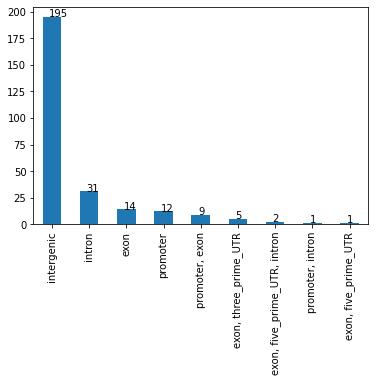

In [144]:
from matplotlib.ticker import MaxNLocator
from matplotlib import pyplot
ax = df.annotation.value_counts().plot(kind='bar')
x_offset = -0.07
y_offset = 0.15
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

for p in ax.patches:
    b = p.get_bbox()
    val = int(b.y1)
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))
ax
pyplot.savefig('../data/res/mirna_all.png',transparent=True, bbox_inches='tight', pad_inches=0)

In [145]:
df.to_csv(path_res, sep='\t', index=None)
print(len(df.index))
print(path_res)

270
../data/res/all_results.csv


In [88]:
#let's have some fun with data

In [89]:
df[df.MITE.notnull()].annotation.value_counts()

intron                   12
intergenic               10
promoter                  2
exon, three_prime_UTR     1
Name: annotation, dtype: int64

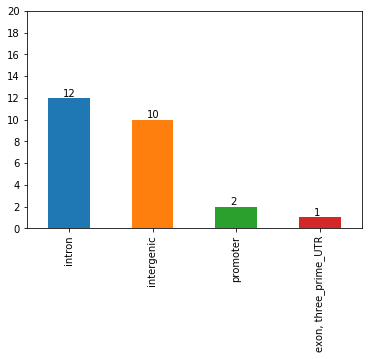

In [90]:
from matplotlib.ticker import MaxNLocator
from matplotlib import pyplot
ax = df[df.MITE.notnull()].annotation.value_counts().plot('bar')
x_offset = -0.07
y_offset = 0.15
ax.set_ylim(0,20)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

for p in ax.patches:
    b = p.get_bbox()
    val = int(b.y1)
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))
ax
pyplot.savefig('../data/res/mirna_mite.png',transparent=True, bbox_inches='tight', pad_inches=0)

In [91]:
len(df.index)

247

In [92]:
print(len(df[df.MITE.notnull()].index))
df[df.MITE.notnull()]

25


,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,22,23,24,seqname,position,start,end,MITE,mirbase,annotation
4,1B:161992200-161992280,sun_all_Cluster_8835_1B_161992200_161992280,81,135,1.069,5,0.919,+,UCUGUUCACAAAUGUAAGACG,106,...,0,0,2,1B,161992200-161992280,161992200,161992280,MITE_1712,hvu-miR6197,intron
10,1D:147896240-147896319,mrcv_mites_MITE_T_120271_1D_147896240_147896319,80,45,0.353,1,1.000,+,UAUAUUUUGGUACGGAGGGAU,22,...,1,0,0,1D,147896240-147896319,147896240,147896319,MITE_1717,NaN,intron
16,2A:133702671-133702770,sun_mites_MITE_T_99232_2A_133702671_133702770,100,2289,18.126,2181,0.983,+,UGAGACGGGUAAUUUGGAACGGAG,1484,...,53,101,2001,2A,133702671-133702770,133702671,133702770,DTT_Tmon_Icarus_BG607724-1,NaN,promoter
19,2A:168984136-168984233,mrcv_mites_MITE_T_102616_2A_168984136_168984233,98,198,1.554,2,0.045,-,UCGGAAUUAGUUGACACUCAAA,86,...,89,63,1,2A,168984136-168984233,168984136,168984233,MITE_253,NaN,intron
29,2B:5671327-5671460,sun_all_Cluster_28681_2B_5671327_5671460,134,562,4.450,504,0.016,-,UAUCUGGACAAAUCUGAGACA,293,...,5,2,4,2B,5671327-5671460,5671327,5671460,DTT_Hvul_Pan_M801L24-1,NaN,intron
36,2B:482720682-482720772,sun_all_Cluster_33132_2B_482720682_482720772,91,102,0.808,91,0.078,-,AUCUUCUAUCGUGGGACGAAG,48,...,1,1,1,2B,482720682-482720772,482720682,482720772,DTT_Taes_Athos_BJ320318-1,NaN,intron
51,3A:19302861-19302943,mrcv_mites_MITE_T_105526_3A_19302861_19302943,83,108,0.848,10,0.972,+,UCCAAUUACUCGUCGUGGUUU,89,...,4,0,3,3A,19302861-19302943,19302861,19302943,DTT_Bdis_BdisStowawayT_consensus-1,tae-miR5175-5p,intron
63,3B:253488744-253488823,mrcv_mites_MITE_T_120628_3B_253488744_253488823,80,1099,8.625,21,0.002,-,AUAUUAUGUGACAGAAGGAGU,715,...,10,0,4,3B,253488744-253488823,253488744,253488823,DTT_Taes_Athos_BJ275764-1,NaN,intron
66,3B:587564305-587564383,mrcv_all_Cluster_13743_3B_587564305_587564383,79,76,0.596,68,1.000,+,AUUGUGUACAGAGGGAGUAGU,67,...,1,0,0,3B,587564305-587564383,587564305,587564383,MITE_867,NaN,intron
74,3D:472405006-472405092,mrcv_mites_MITE_T_110611_3D_472405006_472405092,87,387,3.037,64,0.114,-,ACACUUAUUUCCGAUCGGAGGG,223,...,228,0,30,3D,472405006-472405092,472405006,472405092,MITE_297,NaN,intron


In [93]:
#list(df[df.MITE.notnull()].MITE.unique())

In [94]:
df[(df.MITE.notnull()) & (df.mirbase.notnull())]

,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,22,23,24,seqname,position,start,end,MITE,mirbase,annotation
4,1B:161992200-161992280,sun_all_Cluster_8835_1B_161992200_161992280,81,135,1.069,5,0.919,+,UCUGUUCACAAAUGUAAGACG,106,...,0,0,2,1B,161992200-161992280,161992200,161992280,MITE_1712,hvu-miR6197,intron
51,3A:19302861-19302943,mrcv_mites_MITE_T_105526_3A_19302861_19302943,83,108,0.848,10,0.972,+,UCCAAUUACUCGUCGUGGUUU,89,...,4,0,3,3A,19302861-19302943,19302861,19302943,DTT_Bdis_BdisStowawayT_consensus-1,tae-miR5175-5p,intron
117,5A:552632192-552632284,mrcv_mites_MITE_T_95924_5A_552632192_552632284,93,46,0.361,0,0.000,-,UGCGGCACUUAUUUUGGGACG,40,...,0,0,0,5A,552632192-552632284,552632192,552632284,DTT_Bdis_BdisStowawayF_consensus-1,hvu-miR5049c,intergenic
224,7B:34679825-34679952,mrcv_mites_MITE_T_80536_7B_34679825_34679952,128,184,1.444,26,0.989,+,UGUCGUAGAUUUGUCUAGAUA,99,...,0,1,14,7B,34679825-34679952,34679825,34679952,DTT_Taes_Pan_42j2-6,hvu-miR6191,intergenic


In [ ]:
df[df.MITE.notnull()][['#Locus','Name','MajorRNA','MITE','annotation','mirbase']]

In [96]:
df.to_csv(path_res, sep='\t', index=None)
print(len(df.index))
print(path_res)

247
/home/juan/Desktop/juan/bio/mirna_mite/data/res/all_results.csv


In [ ]:
df[df.duplicated(['MajorRNA'],keep=False)]

In [558]:
df[df.duplicated(['Name'],keep=False)]

,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,22,23,24,seqname,position,start,end,MITE,mirbase,annotation
